In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from PIL import Image
from pathlib import Path
import warnings

plt.rcParams['axes.axisbelow'] = True

In [ ]:
def v0(r,a,b):
    return np.piecewise(r, 
                        [r <= a, (r > a) & (r < b), r >= b], 
                        [lambda r: 0.,  
                        lambda r: np.exp((-4 * np.power((2 * r - a - b), 2)) / (np.power((b - a), 2) - np.power((2 * r - a - b), 2))),
                        lambda r: 0.])


def g(r,a,b):
    return np.piecewise(r, 
                        [r <= a, (r > a) & (r < b), r >= b], 
                        [lambda r: 0.,  
                        lambda r: -(2 * r - a - b) * (a - b) ** 2 / (((b - r) * (a - r)) ** 2),
                        lambda r: 0.])

def dv0(r,a,b):
    return np.piecewise(r, 
                        [r <= a, (r > a) & (r < b), r >= b],
                        [lambda r: 0.,
                        lambda r: g(r,a,b) * v0(r,a,b),
                        lambda r: 0.])

def u_analyt(r,a,b,d):
    return v0(r,a,b) * r ** ((1 - d) * 0.5)

def du_analyt(r,a,b,d):
    return (1 - d) * 0.5 * r ** ((-d - 1) *0.5) * v0(r,a,b) - r ** ((1 - d) * 0.5) * dv0(r,a,b)

def solveWave(T = 3., r_min = 0.0, r_max = 1.8, c = 1.5, a = 0.6, b = 1.2, I = 180, CFL = 0.5, d = 1):
    d = d
    I = I
    r_min = r_min
    r_max = r_max
    c = c
    a = a
    b = b
    i = np.arange(I + 2)
    h = (r_max - r_min) / I
    r_i = np.array([r_min + (iter - 0.5) * h for iter in i])
    CFL = CFL
    tau = CFL * h / c
    t_i = np.arange(0., T, tau)
    u = np.zeros((t_i.size, r_i.size))
    u[0, :] = u_analyt(-r_i,a,b,d)
    u[1, :] = u_analyt(c*tau - r_i,a,b,d)

    for n in range(1, t_i.size - 1):
        for i in range(1, I + 1):
            u[n + 1, i] = 2 * u[n, i] - u[n - 1, i] + (tau * c / h) ** 2 / r_i[i] ** (d - 1) \
                * ((r_i[i] + 0.5 * h) ** (d - 1) * (u[n, i + 1] - u[n, i]) - (r_i[i] - 0.5 * h) ** (d - 1) * (u[n, i] - u[n, i - 1]))
        u[n + 1, 0] = u[n + 1, 1] - h * du_analyt(c * t_i[n + 1] - r_min,a,b,d)
        u[n + 1, -1] = u[n + 1, -2] + h * du_analyt(c * t_i[n + 1] - r_max,a,b,d)

    return u, r_i, t_i

/var/folders/tx/t_y2r90n5gd84735fqzpxzcr0000gn/T/ipykernel_41238/1214760442.py:27: RuntimeWarning: invalid value encountered in divide
  ratioC = np.linalg.norm(diffs1, axis=1, ord= np.inf) / np.linalg.norm(diffs2, axis=1, ord= np.inf)[::k]
/var/folders/tx/t_y2r90n5gd84735fqzpxzcr0000gn/T/ipykernel_41238/1214760442.py:28: RuntimeWarning: invalid value encountered in divide
  ratioL2 = np.linalg.norm(diffs1, axis=1, ord= 2) / np.linalg.norm(diffs2, axis=1, ord= 2)[::k]


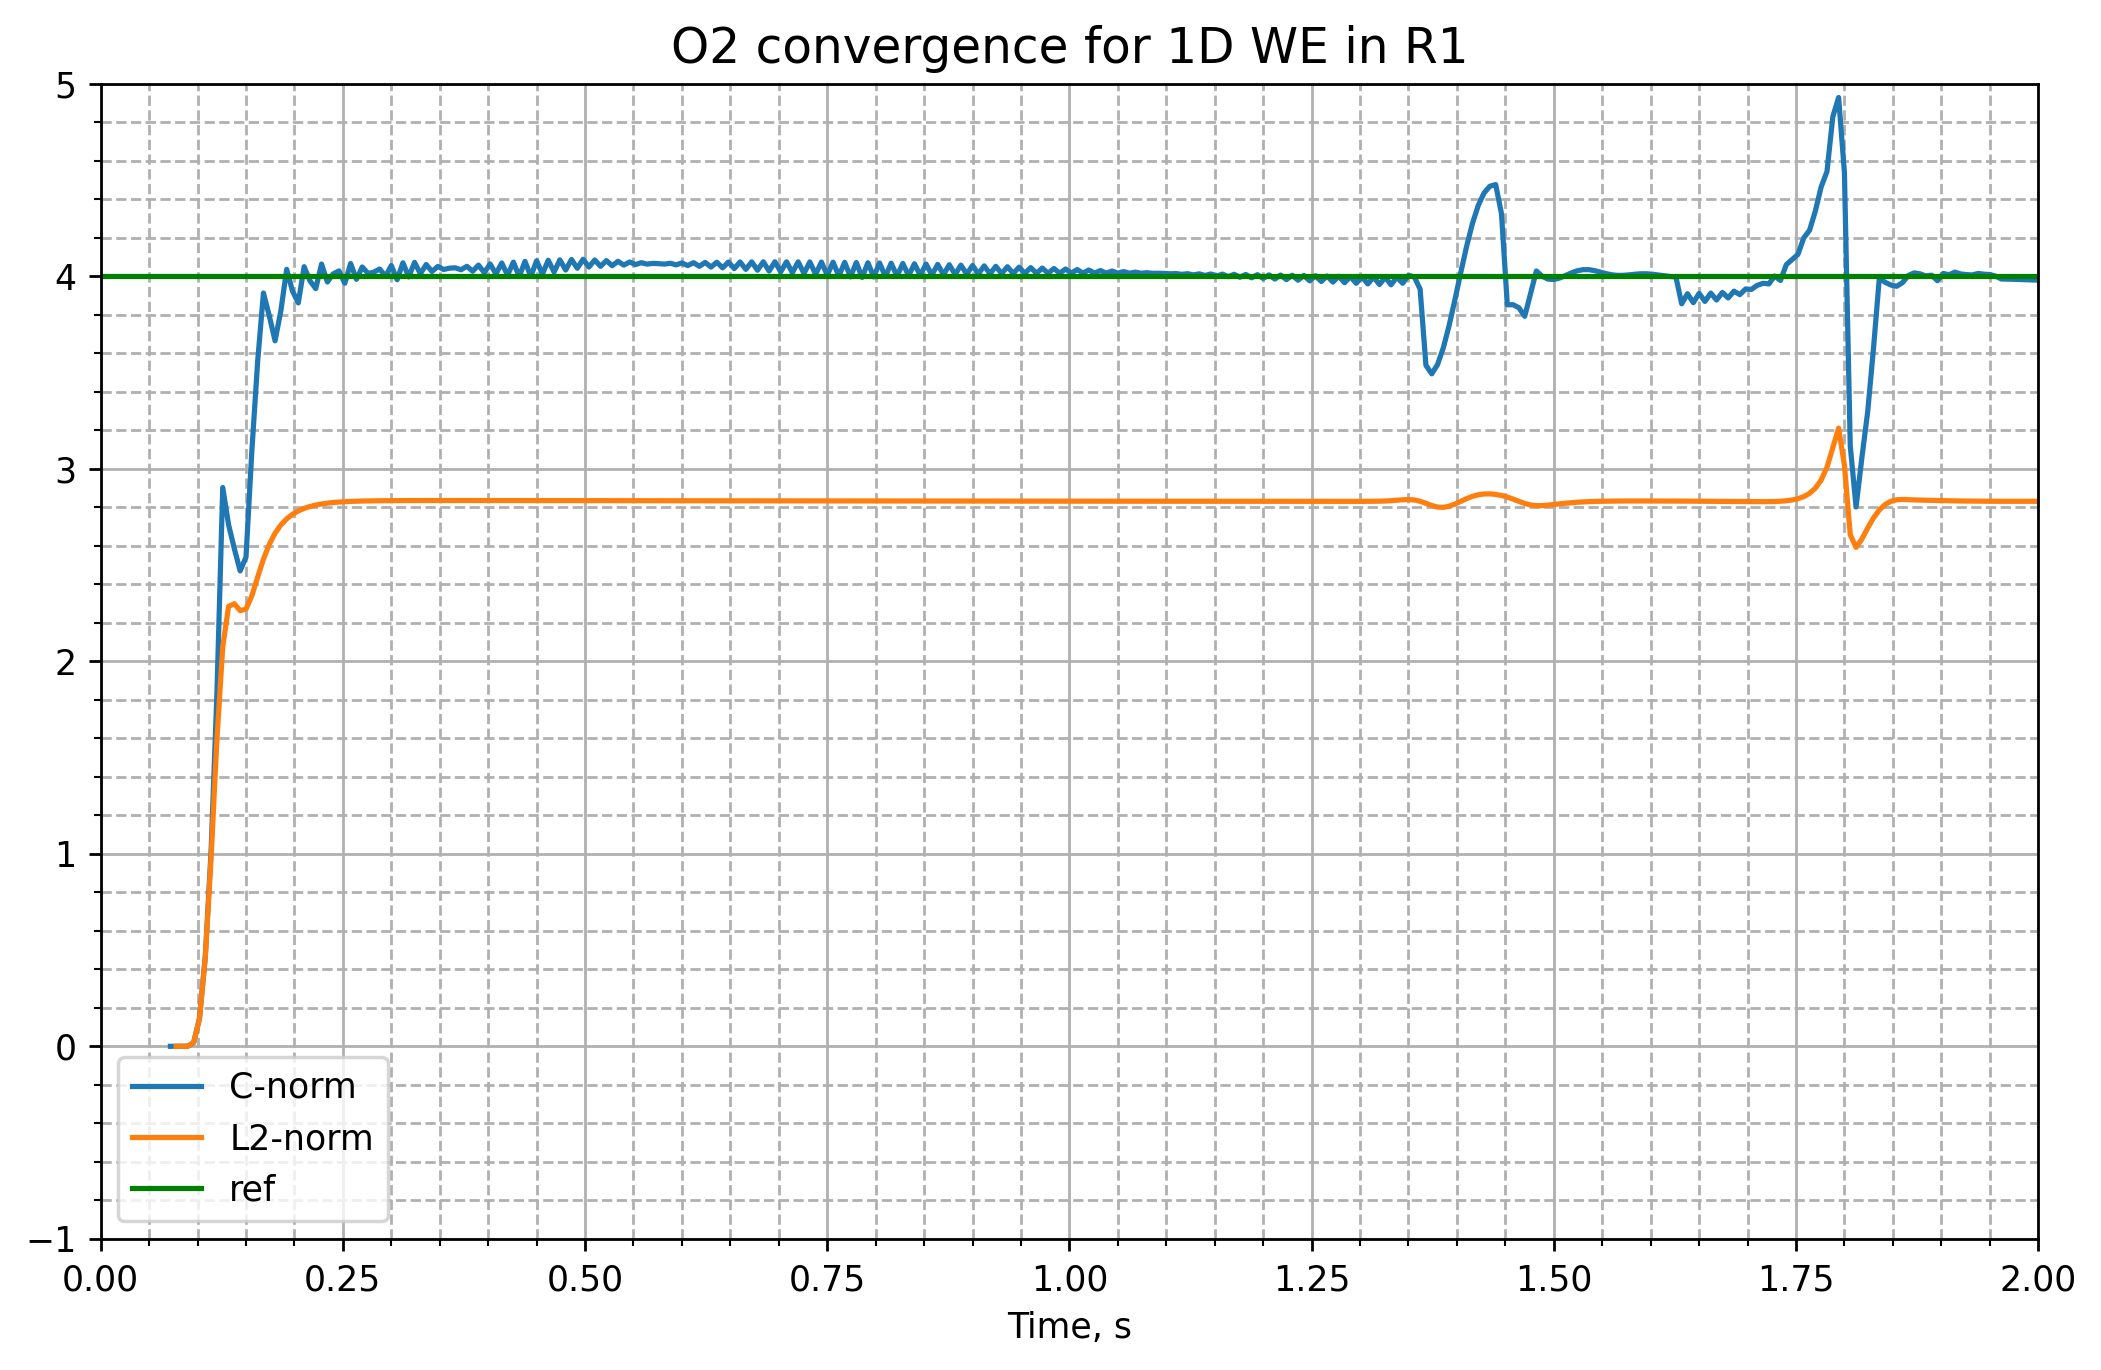

In [114]:
k = 2
base_I = 100
T = 2.
CFL = 0.5
d = 1
c = 1.5
a = 0.1
b = 1.7

I1 = base_I
I2 = base_I*k
u1, r1, t1 =solveWave(c= c, a= a, b = b, I = I1, CFL=CFL,T = T, d = d)
u2, r2, t2 =solveWave(c= c, a= a, b = b, I = I2, CFL=CFL,T = T, d = d)

ua1 = np.zeros((t1.size, r1.size))
ua2 = np.zeros((t2.size, r2.size))
for n, t in enumerate(t1):
        for i in range(0, I1 + 2):
            ua1[n, i] = u_analyt(c * t - r1[i], a,b,d)
for n, t in enumerate(t2):
        for i in range(0, I2 + 2):
            ua2[n, i] = u_analyt(c * t - r2[i], a,b,d)

diffs1 = u1[:, 1:-1] - ua1[:, 1:-1]
diffs2 = u2[:, 1:-1] - ua2[:, 1:-1]

ratioC = np.linalg.norm(diffs1, axis=1, ord= np.inf) / np.linalg.norm(diffs2, axis=1, ord= np.inf)[::k]
ratioL2 = np.linalg.norm(diffs1, axis=1, ord= 2) / np.linalg.norm(diffs2, axis=1, ord= 2)[::k]

x = t1
plt.figure(figsize=(10, 6), dpi= 250)
plt.plot(x, ratioC, label= 'C-norm')
plt.plot(x, ratioL2, label= 'L2-norm')
plt.plot(x, np.ones(x.size) * k**2, label= 'ref', c = 'green')
plt.legend()
plt.title(f'O2 convergence for 1D WE in R{d}', fontsize=14)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle='--')
plt.xlim((0., T))
plt.ylim((-1., k**2 + 1))
plt.minorticks_on()
plt.xlabel('Time, s')
plt.savefig(f'./O2-conv-analyt-{d}D.png', 
        transparent = False,  
        facecolor = 'white'
        )